In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [68]:
data = pd.read_csv("krankenkasse-mit-pbf.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# Encode categorical variables.
data["sex"] = pd.factorize(data['sex'])[0]
data["smoker"] = pd.factorize(data['smoker'])[0]

data['canton'] = pd.factorize(data['canton'])[0]

# Remove encoded categorical variables.

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]

# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [0, 5000, 10000, 20000, 100000]
bin_labels = [0, 1, 2, 3]
data["charges_level"] = pd.cut(data["charges"], bins=bins, labels=bin_labels, include_lowest=True)


data.sort_values(by='charges', ascending=False, na_position='first')
data = data.dropna()

### Data without outliers:

In [69]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]
data_no_outliers

32
166
984
543


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,age,sex,bmi,children,smoker,canton,pbf,charges,charges_level
1,19,0,24.720,0,0,0,35.94,4253,0
2,18,1,29.416,1,1,1,26.86,2494,0
3,28,1,28.800,3,1,1,26.92,3138,0
4,33,1,20.564,0,1,2,7.98,1553,0
5,32,1,25.504,0,1,2,21.84,2768,0
...,...,...,...,...,...,...,...,...,...
1334,50,1,27.176,3,1,2,23.02,5767,1
1335,18,0,27.936,0,1,3,42.18,2547,0
1336,18,0,31.880,0,1,1,49.59,3026,0
1337,21,0,23.040,0,1,0,31.18,2208,0


## Implementation of the ridge regression functions

In [70]:
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):
    
    def __init__(self, opt_method='gd', alpha=1., eta=0.01, maxsteps=100, eps=0.00000001):
        '''Implements a Ridge Regression estimator.
        
        Arguments
        ---------
        alpha:      Regularization proportionality factor. Larger values
                    correspond with stronger regularization.
        opt_method: Optimization method to choose for the cost function.
                    Can be either 'gd' (Gradient Descent) or 'neq'.
        maxsteps:   Maximum number of Gradient Descent steps to take.
        eps:        Epsilon, length of gradient to be reached with Gradient
                    Descent.
        eta:        Fixed step lenght to take at each gradient descent
                    iteration.
        '''
        # parameters
        self.alpha = alpha
        self.opt_method = opt_method
        self.maxsteps = maxsteps
        self.eps = eps
        self.eta = eta
        # attributes
        # model coefficients
        self.beta_ = None
        # values of cost function along gradient descent iterations
        self.costs_ = []       
        
    def fit(self,X,y):
        if(self.opt_method == "neq"):
            type(X)
            return(self.normalequation(X,y))
        else:
            raise Exception("No available optimization method was chosen.")
            
    def normalequation(self,X,y):
        '''Computes the coefficients of the ridge regression cost function
        using the normalequation.
        '''
        
        XX = np.zeros((len(X),X.shape[1]+1))
        XX[:,0] = np.ones(len(X))

        XX[:,1:] = X
        
        #identity matrix with full range
        identity = np.identity(XX.shape[1])
        identity[0,:] = np.zeros(identity.shape[0])
        
        self.beta_ = np.linalg.inv(XX.T @ XX + self.alpha * identity) @ XX.T @ y
        
        return(self.beta_)
    
    @staticmethod 
    def costfunction(beta,X,y,alpha):
        '''Computes and returns the value of the ridge regression cost function.
        '''
        
        cost = np.sum((y - beta[0] + np.dot(X, beta[1:])**2) + alpha * np.sum(beta.T @ beta))
        
        return cost
    
    def predict(self,X):
        '''Computes the predictions of the current model.
            takes in a Xx8 matrix and spits out its respective prediction
        '''
        
        if(self.beta_ is not None):
            predictions = self.beta_[0] + np.dot(X, self.beta_[1:])

            return predictions
        
        raise Exception("Model coefficient haven't been calculated yet. Please call the specific functions to calculate the coefficients.")
        
    def score(self,y,y_hat):
        '''Returns R^2 for given input/output data given the model
        coefficients. 1 - (sum of squares of residuals / total sum of squares) | sum of squares = sum of (yi - mean(y))^2
        '''
        
        ss_res = np.sum((y - y_hat)**2)
                        
        ss_tot = np.sum((y-np.mean(y))**2)
        
        score = 1-(ss_res/ss_tot)
        
        return score
    
    @staticmethod
    def mae(y, y_hat):
        mae =  (1 / len(y)) * np.sum(abs(y-y_hat))
        return mae

In [71]:
from sklearn.model_selection import train_test_split

labels = np.array(data['charges'])
# The data we want to split = 'input'
input = data.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)
print(input)

# The argument for the split function has to be an array
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

      age  sex  children  smoker  canton    pbf
1      19    0         0       0       0  35.94
2      18    1         1       1       1  26.86
3      28    1         3       1       1  26.92
4      33    1         0       1       2   7.98
5      32    1         0       1       2  21.84
...   ...  ...       ...     ...     ...    ...
1334   50    1         3       1       2  23.02
1335   18    0         0       1       3  42.18
1336   18    0         0       1       1  49.59
1337   21    0         0       1       0  31.18
1338   61    0         0       0       2  38.63

[1337 rows x 6 columns]


In [72]:
##instantiate regressor
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 34.04340434)
ridge1 = RidgeRegressor.fit(train_input, train_labels) 

print("Ridge Regressors:", ridge1)

#predict function
test = test_input
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
predics = RidgeRegressor.predict(test)
print("Predicted Charges: ", predics[10:16:])

Ridge Regressors: [-7304.01435109   159.88496609  4283.95671518   116.42148036
 -6784.29470952   397.99832847   323.57674641]
Input Data:  [[57.    0.    0.    1.    3.   32.38]
 [61.    0.    0.    1.    2.   40.36]
 [32.    1.    1.    0.    3.   27.74]
 [61.    0.    0.    1.    0.   60.4 ]
 [35.    0.    2.    1.    3.   51.17]
 [44.    0.    2.    1.    1.   29.54]]
Real Charges:  [ 4126  7775 10859 17131  8304  3137]
Predicted Charges:  [ 6696.54404058  9520.2280128  12382.69669006 15208.70935385
  9491.92481231  3135.92782539]


In [73]:
#score function
score = RidgeRegressor.score(test_labels, predics)
print("Score:", format(score, 'f'))
mae = RidgeRegressor.mae(test_labels, predics)
print("Mean Absolute Error:", format(mae, "f"))

Score: 0.772169
Mean Absolute Error: 1869.593937


Dropping BMI does not have much of a difference actually.

##### By the way, the sklearn prints the same results for the regression

In [74]:
#SKLEARN?
from sklearn.linear_model import Ridge
# define model
model = Ridge(alpha=1.0)
# fit model
model.fit(train_input, train_labels)

RidgeRegressor = Ridge(alpha=1.0)
RidgeRegressor.fit(train_input, train_labels)

predics = RidgeRegressor.predict(test_input)

print("sklearn vs own formula prediction comparison:", model.predict(test_input) == predics)

sklearn vs own formula prediction comparison: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


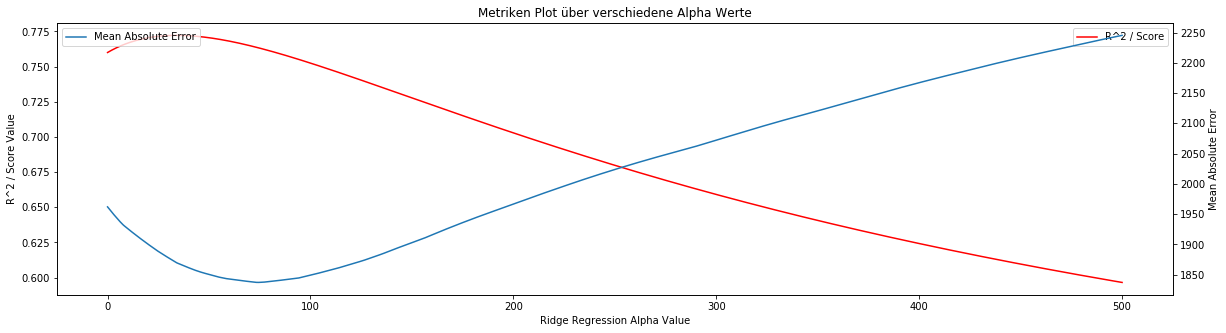

R^2/Score max value: 0.7721688908564154
Alpha value for R^2/Score max value: 34.05340534053405

Mean Absolute Error min value: 1837.033319427547
Alpha value for Mean Absolute Error min value: 74.007400740074

Mean Absolute Error where R^2 is max 1954.8297696968734
R^2/Score value where MAE is minimum: 0.7628559922418346


In [75]:
##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input, train_labels)

    predics = RidgeRegressor.predict(test_input)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### Standardizing data seems to reduce MAE and only marginally decrease the score by 0.02

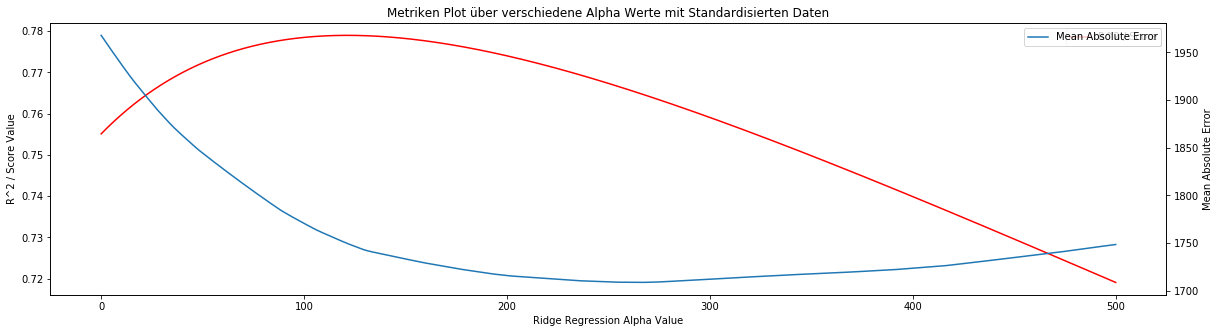

R^2/Score max value: 0.77900410383755
Alpha value for R^2/Score max value: 121.3121312131213

Mean Absolute Error min value: 1708.5625491557403
Alpha value for Mean Absolute Error min value: 265.47654765476545

Mean Absolute Error where R^2 is max 1949.2845041505225
R^2/Score value where MAE is minimum: 0.7611500538422147


In [76]:
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte mit Standardisierten Daten")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

[3.58185088 3.29063819 3.2928695  ... 3.9037892  3.43977686 3.65402918]


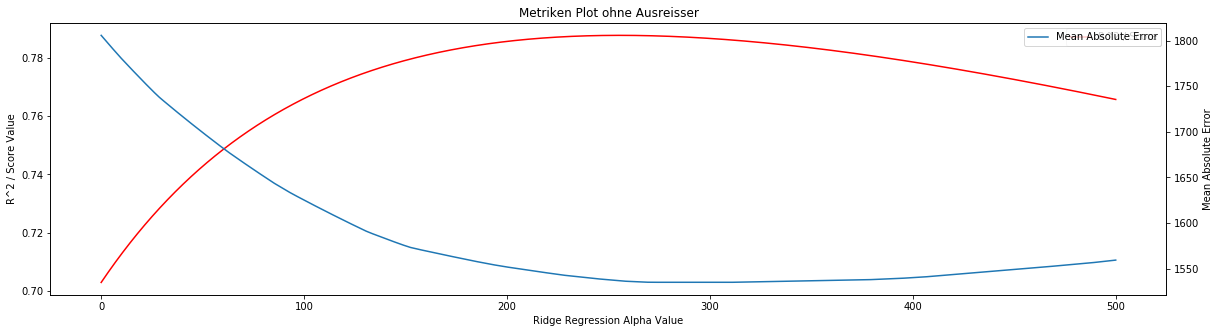

R^2/Score max value: 0.7877720192332744
Alpha value for R^2/Score max value: 255.5255525552555

Mean Absolute Error min value: 1534.797279208472
Alpha value for Mean Absolute Error min value: 307.3807380738074

Mean Absolute Error where R^2 is max 1773.7562976439215
R^2/Score value where MAE is minimum: 0.7174978681246593


In [77]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

print(np.log(input[:,5]))

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### Without outliers we can bring down the mean absolute error by 200 and the R^2/Score finally gets bigger. I don't know why the R^2/Score only rises when removing outliers. The max value of the score and the min value of the MAE occur at similar alpha values. 

##### What does it look like when we differentiate between smoker and non smoker and do for each one a seperate regression? The following example uses only smokers and the MAE is 1000 but with non smokers the MAE is 3000...

In [78]:
data_smoker = data_no_outliers[data_no_outliers['smoker'] == 1]
data_non_smoker = data_no_outliers[data_no_outliers['smoker'] == 0]
print(type(data_non_smoker), type(data_no_outliers))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


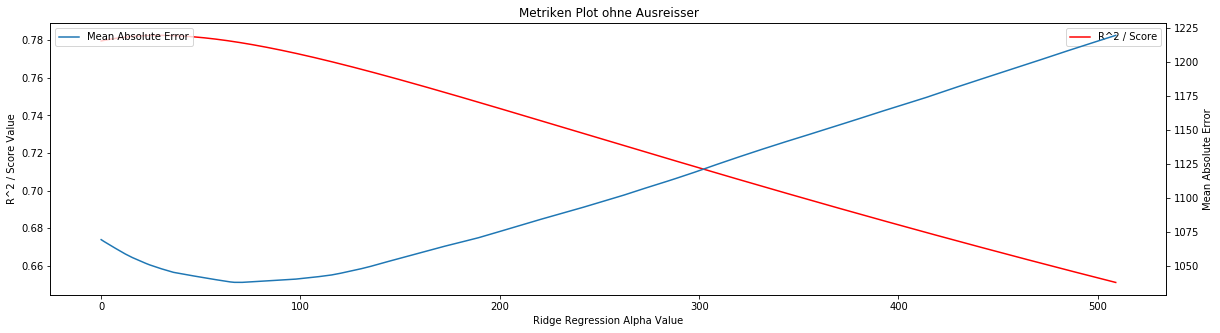

R^2/Score max value: 0.7825769313991155
Alpha value for R^2/Score max value: 29.168616861686168

Mean Absolute Error min value: 1037.9111602231842
Alpha value for Mean Absolute Error min value: 70.09630963096309

Mean Absolute Error where R^2 is max 1067.930778815283
R^2/Score value where MAE is minimum: 0.7803303344354299


In [94]:
labels = np.array(data_smoker['charges'])
# The data we want to split = 'input'
input = data_smoker.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1).drop('smoker', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 509, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    
    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### In the following exmaple i tried taking the logarithm of age and pbf to see if it improves the model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


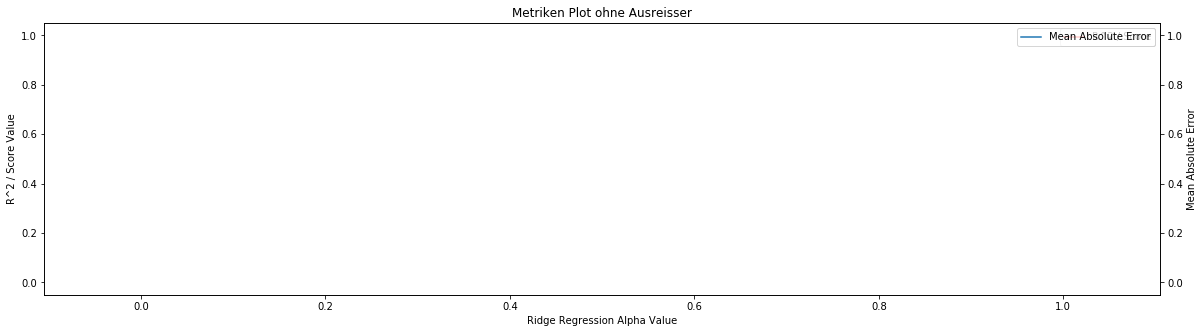

R^2/Score max value: nan


IndexError: index 0 is out of bounds for axis 0 with size 0

In [95]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

alphaRange = np.linspace(0, 509, 1000)

input[:,0] = np.log(input[:,0])
input[:,5] = np.log(input[:,5])

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.1, random_state = 42) 
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)
##instantiate regressor
scoreArray = []
maeArray = []
for j in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

### PCA:

In the following PCA example, age, smoker Y/N, bmi and pbf were orthogonalized and in the dataframe that was used for the regression, the orthogonalized versions of those features were used instead of the original ones. Furthermore, to match our marketing strategy, biological sex was dropped all together as a feature. Dropping this feature resulted in a slightly better version of the model.

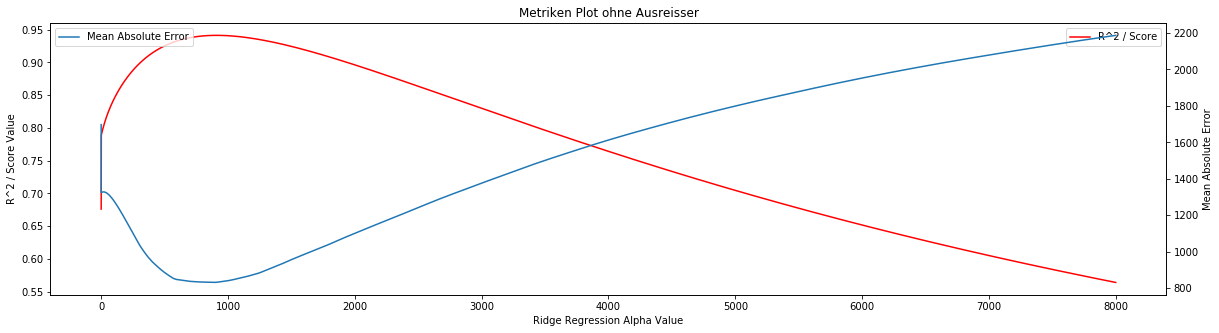

R^2/Score max value: 0.9413944206539372
Alpha value for R^2/Score max value: 910.0455022751138

Mean Absolute Error min value: 830.517261768306
Alpha value for Mean Absolute Error min value: 893.6446822341118

Mean Absolute Error where R^2 is max 974.8077103552793
R^2/Score value where MAE is minimum: 0.9079717497781917


In [96]:
pca_data = data_no_outliers[['age', 'smoker', 'bmi', 'pbf']]
X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 
        
U, S, Vt = np.linalg.svd(X, full_matrices= False)
        
components_ = np.real(Vt)

idx = np.argsort(S)[::-1]
        
#eigenwert berechnen und varianz berechnen mit np.cov weil ich mit svd irgendwo noch einen Fehler hatte
        
test = np.cov(X)
(eigvalues_, components) = np.linalg.eigh(test)
        
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers
data4[['age', 'smoker', 'canton', 'pbf']] = components_.T

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1)

# The argument for the split function has to be an array
input = np.array(input)

alphaRange = np.linspace(0, 8000, 20000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.1, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

scoreArray = []
maeArray = []

for j in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

In [97]:
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 48)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

predics = RidgeRegressor.predict(test_input_standardize)

test = test_input_standardize
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
print("Predicted Charges: ", predics[10:16:])

Input Data:  [[-0.31292807  0.31292807  0.76697577  0.37762372 -0.80217758  0.33070189
   0.08122189  0.46709937]
 [-0.75636556  0.75636556  0.76697577 -0.40743361  0.81919885  0.02888079
   0.36771252  0.46709937]
 [-0.42771862  0.42771862 -0.08240236  0.37961093 -0.63309593  0.3364005
   1.12505693  1.7710851 ]
 [ 0.84205362 -0.84205362 -0.08240236  0.06399419  0.30784793  0.15068773
  -0.95169692 -0.83688636]
 [-1.80677777  1.80677777  3.31511016 -3.59905361  3.89833421 -1.22725885
   0.34854845  0.46709937]
 [-0.54879907  0.54879907 -0.93178049  2.00049971  3.77062852 -6.24249534
   0.87907768  0.46709937]]
Real Charges:  [ 6556  7737 10859  2298  7658  9845]
Predicted Charges:  [ 7449.37080911  8958.43165908 13659.20416264  1218.84788363
  8942.13403695 11647.19808313]


With PCA of the biggest influencer of charges (age, smoker (Y/N), pbf, bmi) the MAE comes down is reduced to 831 and the score is actually over .9

## TODO?

- Backwards/Forwards Selection
- ✓ (for alpha) Metrics
- Check factorization?
- ✓ (just the children outliers and the extremely high bmi for 20 years odl) Check outliers
- ✓ Logarithms?
- ✓ (For the biggest influencer of charges) Orthogonalization using PCA?
- Polynomials?
- Se
- ✓ (For smoker it's much more accurate) Aufteilung in mehrere regression pro raucherklassen

After first deep dive TODO:
- PCA for more split up categories like in example for smokers